# In theory, the model should be able to create its own descriptors directly from SMILES.

In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tdc.single_pred import Tox
from rdkit.Chem import PandasTools, AllChem
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.metrics import explained_variance_score, max_error, \
                     mean_absolute_error, mean_squared_error, r2_score

In [2]:
num_workers = 0

In [3]:
data = Tox(name='LD50_Zhu').get_data()

Found local copy...
Loading...
Done!


In [4]:
data

,Drug_ID,Drug,Y
0,"Diazene, diphenyl-, 1-oxide",[O-][N+](=Nc1ccccc1)c1ccccc1,2.505
1,"Methane, tribromo-",BrC(Br)Br,2.343
2,Bromoethene (9CI),C=CBr,2.330
3,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
4,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729
...,...,...,...
7380,"Isocyanic acid, (alpha,alpha,alpha-trifluoro-o...",O=C=Nc1ccccc1C(F)(F)F,1.427
7381,"1,3-Benzenediamine, 4-(1,1,2,2-tetrafluoroetho...",Nc1ccc(OC(F)(F)C(F)F)c(N)c1,2.321
7382,"Propanenitrile, 3-((2-(acetyloxy)ethyl)phenyla...",CC(=O)OCCN(CCC#N)c1ccccc1,2.050
7383,"IH-Indene-1,3(2H)-dione, 2-(2-methyl-1-(2-(1-p...",CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951


In [5]:
PandasTools.AddMoleculeColumnToFrame(data,'Drug','Molecule')
if data.Molecule.isna().sum()==0:
    print('Smiles loaded')

Smiles loaded


,Drug_ID,Drug,Y,Molecule
5541,Bicyclo(2.2.1)hept-2-ene,C1=CC2CCC1C2,0.921,
6111,Ethylenetetracarbonitrile,N#CC(C#N)=C(C#N)C#N,4.409,
732,"Pyridine, 2,6-dimethyl-",Cc1cccc(C)n1,2.428,

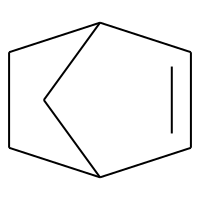
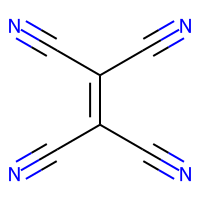
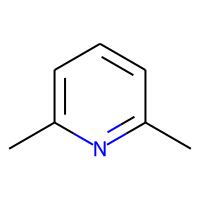

In [6]:
data.sample(3)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from molvecgen.vectorizers import SmilesVectorizer

In [9]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(data.Molecule.values)

In [10]:
print(smivec.charset)
smivec.dims

2-CS8s(45N])=cI1rPn7io+6Hl[F3#BO^$?


(175, 35)

In [11]:
y = data.Y.values.reshape((-1,1))
X = data.Molecule.values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)

In [13]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [14]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
        
    def __len__(self):
        return len(self.molecules)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [15]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([-1.07591829]))

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
X_validation_t.shape

cpu


torch.Size([333, 175, 35])

In [17]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
         
        length = dims[0]
        number_tokens = dims[1]
         
        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size)
        self.activation = nn.ReLU()
        self.fc_out = nn.Linear(hidden_size, out_size)
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x) 
        out = self.dropout(h_n) 
        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out) 
        out = self.fc_out(out)
        return out


In [18]:
epochs = 100
dims = smivec.dims
lstm_size = 128
hidden_size = 128
dropout_rate = 0.50
output_size = 1
batch_size = 128
learning_rate = 0.003

In [19]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
#model.cuda()
model

Net(
  (lstm): LSTM(35, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [20]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[[-0.0794]]], grad_fn=<AddBackward0>)

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, 
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [23]:
for smiles, labels in train_loader:
    break

In [24]:
model.train()
train_losses = []
validation_losses = []

for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        smiles = torch.tensor(smiles, device=device).float()
        labels = torch.tensor(labels, device=device).float()
        optimizer.zero_grad()

        output = model(smiles)
        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
         
        running_loss += loss.item()
    else:      
        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()
         
        lr_scheduler.step(validation_loss)
         
        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))

Epoch 1, Training loss: 0.98 Validation loss: 0.70
Epoch 2, Training loss: 0.84 Validation loss: 0.82
Epoch 3, Training loss: 0.78 Validation loss: 0.65
Epoch 4, Training loss: 0.76 Validation loss: 0.63
Epoch 5, Training loss: 0.71 Validation loss: 0.65
Epoch 6, Training loss: 0.70 Validation loss: 0.63
Epoch 7, Training loss: 0.70 Validation loss: 0.63
Epoch 8, Training loss: 0.71 Validation loss: 0.65
Epoch 9, Training loss: 0.70 Validation loss: 0.64
Epoch 10, Training loss: 0.71 Validation loss: 0.58
Epoch 11, Training loss: 0.71 Validation loss: 0.71
Epoch 12, Training loss: 0.71 Validation loss: 0.70
Epoch 13, Training loss: 0.70 Validation loss: 0.64
Epoch 14, Training loss: 0.69 Validation loss: 0.58
Epoch 15, Training loss: 0.68 Validation loss: 0.60
Epoch 16, Training loss: 0.76 Validation loss: 0.64
Epoch 17, Training loss: 0.67 Validation loss: 0.62
Epoch 18, Training loss: 0.66 Validation loss: 0.62
Epoch 19, Training loss: 0.67 Validation loss: 0.63
Epoch 20, Training lo

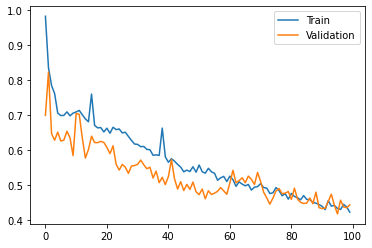

In [25]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.legend()
plt.show()

In [26]:
model.eval()
y_pred_validation = model(X_validation_t)

In [27]:
torch.mean(( y_validation_t - y_pred_validation ) ** 2).item()

0.4442553222179413

In [28]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()

In [29]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.426	Test RMSE: 0.383


In [30]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

y_true = y_test
y_pred = flatten(y_pred_test)

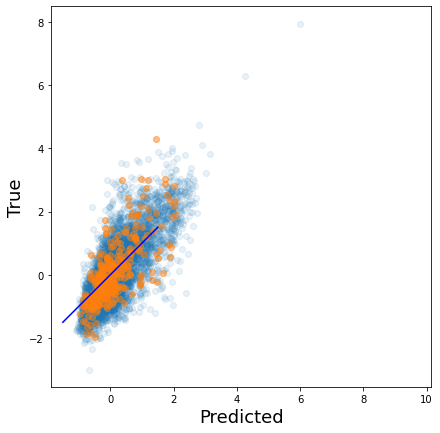

In [31]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.axis('square')
fig = plt.gcf()
fig.set_size_inches(7, 7)

In [32]:
def assess_model(y_true, y_pred, X_train, y_train):

    def calc_metrics(y_pred):
        score1 = max_error(y_true, y_pred)
        score2 = mean_absolute_error(y_true, y_pred)
        score3 = mean_squared_error(y_true, y_pred)
        score4 = explained_variance_score(y_true, y_pred)
        score5 = r2_score(y_true, y_pred)
        return score1,score2,score3,score4,score5

    dummy1 = DummyRegressor(strategy="mean")
    dummy1.fit(X_train, y_train)
    dummy_mean = dummy1.predict(X_test)

    dummy2 = DummyRegressor(strategy="median")
    dummy2.fit(X_train, y_train)
    dummy_median = dummy2.predict(X_test)

    dummy3 = DummyRegressor(strategy="quantile", quantile=0.0)
    dummy3.fit(X_train, y_train)
    dummy_quantile00 = dummy3.predict(X_test)

    dummy4 = DummyRegressor(strategy="quantile", quantile=0.5)
    dummy4.fit(X_train, y_train)
    dummy_quantile05 = dummy4.predict(X_test)

    dummy5 = DummyRegressor(strategy="quantile", quantile=1.0)
    dummy5.fit(X_train, y_train)
    dummy_quantile10 = dummy5.predict(X_test)
    
    results = [
        calc_metrics(y_pred),
        calc_metrics(dummy_mean),
        calc_metrics(dummy_median),
        calc_metrics(dummy_quantile00),
        calc_metrics(dummy_quantile05),
        calc_metrics(dummy_quantile10)
    ]

    df = pd.DataFrame(results).T 

    df.columns = ['Model', 'dummy(Mean)', 'dummy(Median)', 
                  'dummy(Min Quantile)', 'dummy(Median Quantile)', 
                  'dummy(Max Quantile)']

    df = df.rename(index={0: "max error", 1: "MAE", 2: "MSE", 3:"explained", 4:"r2"})
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    df = df.T

    def highlight_max(data, color='lightgreen'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  
            is_max = data == data.max()
            return [attr if v else '' for v in is_max]

    def highlight_min(data, color='lightgreen'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  
            is_min = data == data.min()
            return [attr if v else '' for v in is_min]


    return df.style.apply(highlight_min, subset=['max error', 'MAE', 'MSE']).\
             apply(highlight_max, subset=['explained', 'r2'])

In [33]:
print("\n"+"LSTM")
print("epochs=600, lstm_size = 128, hidden_size=128, dropout=0.5, lr=0.003")
assess_model(y_true, y_pred, X_train, y_train)


LSTM
epochs=600, lstm_size = 128, hidden_size=128, dropout=0.5, lr=0.003


,max error,MAE,MSE,explained,r2
Model,2.669370,0.489112,0.383240,0.578705,0.565545
dummy(Mean),3.923546,0.741133,0.883702,0.000000,-0.001798
dummy(Median),4.106296,0.717601,0.902543,0.000000,-0.023156
dummy(Min Quantile),6.916357,2.952983,9.602223,-0.000000,-9.885441
dummy(Median Quantile),4.106296,0.717601,0.902543,0.000000,-0.023156
dummy(Max Quantile),9.860083,7.978488,64.538393,0.000000,-72.163151


# Again, the model outperforms any dummy model.
# In addition, LSTM gives a bit more accurate predictions than the feedforward neural network with descriptors.